In [32]:
# %% Libraries

import time
import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from bs4 import BeautifulSoup
import docx
import re
import os
from googletrans import Translator
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from keybert import KeyBERT
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from collections import defaultdict
import numpy as np
import nltk
from sklearn.decomposition import LatentDirichletAllocation
nltk.download('punkt')
import pickle
import numpy as np
from collections import defaultdict
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from keybert import KeyBERT
import nltk
nltk.download('vader_lexicon')

import seaborn as sns
import matplotlib.pyplot as plt
import pyLDAvis.sklearn_model as sklearn_lda


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\TE.5586\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\TE.5586\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


ModuleNotFoundError: No module named 'pyLDAvis.sklearn_model'

In [ ]:
# %% DATA COLLECTION & PROCESSING. Part 1. Web scraping of job applications from EY careers

def scrape_ey_jobs(country: str, num_pages: int) -> pd.DataFrame:
    """
    Scrapes job postings and full descriptions from EY's career site for a given country to enable text-based analysis of employer branding.

    Process:
    -----------------
    1. Launch a headless Chrome browser session using Selenium.
    2. Construct EY job search URLs for the specified country and loop through multiple pages of listings.
    3. On each results page, extract job titles, locations, and direct URLs to the detailed job pages using BeautifulSoup.
    4. Visit each individual job URL and extract the full job description content from the detail view.
    5. Append all job metadata and descriptions into a pandas DataFrame with standardized columns.
    6. Close the browser session and return the complete DataFrame for downstream NLP and hypothesis testing.


    Parameters:
    ----------
    country : str
        The country code (e.g., 'United States', 'Germany', 'Ukraine') used for filtering jobs.
        This should match the URL parameter value for the country on the EY job site.
    
    num_pages : int
        The number of pages of results to scrape (each page contains up to 25 jobs).

    Returns:
    -------
    pd.DataFrame
        A DataFrame with the following columns:
        - 'Title': Job title
        - 'Location': Job location
        - 'URL': Direct link to the job post
        - 'Job Description': Full job description text
    """

    # --- Setup headless Chrome ---
    options = Options()
    options.add_argument("--headless")
    driver = webdriver.Chrome(options=options)

    base_url = "https://careers.ey.com"
    search_base = f"{base_url}/ey/search/?createNewAlert=false&q=&locationsearch=&optionsFacetsDD_country={country}&optionsFacetsDD_customfield1="

    jobs = []

    # --- Loop through specified pages ---
    for page_num in range(num_pages):
        startrow = page_num * 25
        page_url = f"{search_base}&startrow={startrow}"
        print(f"🔎 Fetching: Page {page_num + 1} | {page_url}")
        
        driver.get(page_url)
        time.sleep(5)

        soup = BeautifulSoup(driver.page_source, "html.parser")
        job_cards = soup.select("tr.data-row")

        for job_card in job_cards:
            try:
                title_elem = job_card.select_one("a.jobTitle-link")
                title = title_elem.get_text(strip=True)
                job_url = base_url + title_elem["href"]
                location = job_card.select_one("span.jobLocation").get_text(strip=True)

                jobs.append({
                    "Title": title,
                    "Location": location,
                    "URL": job_url
                })
            except Exception as e:
                print(f"⚠️ Error parsing job card: {e}")
                continue

    # --- Scrape job descriptions with progress tracking ---
    descriptions = []

    print(f"\n📄 Fetching job descriptions for {len(jobs)} jobs...\n")
    for idx, job in enumerate(jobs, start=1):
        try:
            print(f"📝 [{idx}/{len(jobs)}] Fetching: {job['Title'][:60]}")
            driver.get(job["URL"])
            time.sleep(8)

            soup = BeautifulSoup(driver.page_source, "html.parser")
            body = soup.find("span", class_="jobdescription")

            if body:
                text = body.get_text(separator=" ", strip=True)
                descriptions.append(text)
            else:
                descriptions.append("No description found.")
        except Exception as e:
            print(f"❌ Error fetching {job['URL']}: {e}")
            descriptions.append("Error loading or parsing page.")

    driver.quit()

    # --- Return DataFrame ---
    df = pd.DataFrame(jobs)
    df["Job Description"] = descriptions
    return df

df_jobs_ua = scrape_ey_jobs('UA', 20)
df_jobs_ge = scrape_ey_jobs('DE', 20)
df_jobs_us = scrape_ey_jobs('US', 20)


In [ ]:
# %% DATA COLLECTION & PROCESSING. Part 2. Transformation of web scraped data of job applications from EY careers

from deep_translator import GoogleTranslator
import pandas as pd
import re
import unicodedata

# --- Load Excel sheets ---
df_jobs_ua = pd.read_excel("EY_jobs_text_analysis.xlsx", sheet_name="Jobs_UA")
df_jobs_ge = pd.read_excel("EY_jobs_text_analysis.xlsx", sheet_name="Jobs_GE")
df_jobs_us = pd.read_excel("EY_jobs_text_analysis.xlsx", sheet_name="Jobs_USA")

def clean_text(text):
    """
    Remove unsupported or problematic symbols from the input text to improve translation reliability.
    """
    # Normalize unicode and remove control characters
    text = unicodedata.normalize('NFKC', text)
    text = re.sub(r'[\r\n\t]', ' ', text)  # Replace line breaks/tabs
    text = re.sub(r'[^\x00-\x7Fа-яА-ЯёЁіІїЇєЄa-zA-Z0-9\s.,;:!?\'"-]', '', text)  # Remove symbols like emojis, currency, etc.
    text = re.sub(r'\s+', ' ', text).strip()  # Collapse multiple spaces
    return text

def translate_column(df, column_name, src_lang='auto', dest_lang='en'):
    """
    Translates text in a DataFrame column after cleaning, with single-attempt logic.
    """
    new_column_name = f"{column_name} (EN)"

    def clean_and_translate(text):
        cleaned = clean_text(str(text))
        try:
            return GoogleTranslator(source=src_lang, target=dest_lang).translate(cleaned)
        except Exception as e:
            print(f"⚠️ Translation failed for: {cleaned[:50]}... | Error: {e}")
            return text  # fallback to original

    df[new_column_name] = df[column_name].apply(clean_and_translate)
    return df

#df_jobs_ua = translate_column(df_jobs_ua, 'Job Description', src_lang='uk', dest_lang='en')
#df_jobs_ge = translate_column(df_jobs_ge, 'Job Description', src_lang='de', dest_lang='en')

df_jobs_ua['Job Description (EN)'] = df_jobs_ua['Job Description (EN)'].apply(clean_text)
df_jobs_ge['Job Description (EN)'] = df_jobs_ge['Job Description (EN)'].apply(clean_text)
df_jobs_us['Job Description (EN)'] = df_jobs_us['Job Description (EN)'].apply(clean_text)

with pd.ExcelWriter("EY_jobs_text_analysis.xlsx", engine="xlsxwriter") as writer:
    df_jobs_ua.to_excel(writer, sheet_name="Jobs_UA", index=False)
    df_jobs_ge.to_excel(writer, sheet_name="Jobs_GE", index=False)
    df_jobs_us.to_excel(writer, sheet_name="Jobs_USA", index=False) 

In [ ]:
# %% DATA COLLECTION & PROCESSING. Part 3. Transformation of reviews from Glassdoor

def extract_reviews_to_excel(input_docx_path: str, sheet_name: str, output_excel_path: str = "EY_jobs_text_analysis.xlsx"):
    """
    Parses employee reviews from a structured .docx file and writes them into a new sheet in an Excel workbook.

    Process:
    -----------------
    1. Load the .docx file and read through its paragraphs sequentially.
    2. Identify key review components using fixed patterns and labels (e.g., rating format, 'Pros', 'Cons').
    3. Use a state machine to assign paragraphs to structured fields like Rating, Title, Position, Pros, etc.
    4. Aggregate each complete review into a dictionary and build a list of reviews.
    5. Convert the list into a pandas DataFrame.
    6. If the Excel file does not exist, create it and add a placeholder sheet.
    7. Append the extracted review DataFrame to the specified sheet in the Excel file, replacing any existing sheet with the same name.
    8. Return the path to the saved Excel file.

    Parameters:
    ----------
    input_docx_path : str
        Path to the input .docx Word document containing employee reviews.

    sheet_name : str
        Name of the Excel sheet to create or replace with the extracted reviews.

    output_excel_path : str, optional
        Path to the output Excel file (default is "EY_jobs_text_analysis.xlsx").

    Returns:
    -------
    str
        The path to the Excel file where the new sheet was saved.
    """

    # Load the Word document
    doc = docx.Document(input_docx_path)

    def is_rating(text):
        return bool(re.match(r'^\d\.\d$', text.strip()))

    reviews = []
    temp_review = {}
    state = 'INIT'

    for para in doc.paragraphs:
        text = para.text.strip()
        if not text:
            continue

        if is_rating(text):
            if temp_review:
                reviews.append(temp_review)
                temp_review = {}
            temp_review['Rating'] = text
            state = 'RATING'
        elif state == 'RATING':
            temp_review['Date'] = text
            state = 'DATE'
        elif state == 'DATE':
            temp_review['Title'] = text
            state = 'TITLE'
        elif state == 'TITLE':
            temp_review['Position'] = text
            state = 'POSITION'
        elif state == 'POSITION':
            temp_review['Employment Status'] = text
            state = 'EMPLOYMENT'
        elif state == 'EMPLOYMENT':
            temp_review['Location'] = text
            state = 'LOCATION'
        elif text == 'Pros':
            state = 'PROS'
        elif text == 'Cons':
            state = 'CONS'
        elif text == 'Advice to Management':
            state = 'ADVICE'
        elif state == 'PROS':
            temp_review['Pros'] = text
            state = 'AFTER_PROS'
        elif state == 'CONS':
            temp_review['Cons'] = text
            state = 'AFTER_CONS'
        elif state == 'ADVICE':
            temp_review['Advice'] = text
            state = 'AFTER_ADVICE'

    if temp_review:
        reviews.append(temp_review)

    df = pd.DataFrame(reviews)

    # Ensure file exists, or create an empty one first
    if not os.path.exists(output_excel_path):
        with pd.ExcelWriter(output_excel_path, engine='openpyxl') as writer:
            pd.DataFrame().to_excel(writer, sheet_name='TempInit', index=False)

    # Always append new sheet
    with pd.ExcelWriter(output_excel_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
        df.to_excel(writer, sheet_name=sheet_name, index=False)

    return output_excel_path

extract_reviews_to_excel("Input/Glassdoor reviews_EY Ukraine.docx", sheet_name="Reviews_UA")
extract_reviews_to_excel("Input/Glassdoor reviews_EY Germany.docx", sheet_name="Reviews_GE")
extract_reviews_to_excel("Input/Glassdoor reviews_EY USA.docx", sheet_name="Reviews_USA")


In [ ]:
# %% DATA COLLECTION & PROCESSING. Part 4. Text analysis of the job applications

def analyze_text_data_by_country(
    country_codes: list,
    dataframes: list,
    top_n_tfidf: int = 30,
    top_n_keybert: int = 50,
    ngram_range: tuple = (1, 2),
    save_path: str = "text_analysis_results.pkl"
) -> dict:
    """
    Performs keyword extraction, sentiment analysis, and topic modeling on job descriptions
    for multiple countries and returns structured results in a nested dictionary, with optional saving.

    
    Process:
    -------------------------
    1. Iterates through each country and its associated DataFrame.
    2. Extracts and processes the 'Job Description (EN)' column.
    3. Applies text analysis techniques:
       - TF-IDF for top keyword scoring.
       - Collocation analysis for bigram frequency.
       - KeyBERT for semantic keyword relevance.
       - VADER for sentiment analysis (overall and by themes).
       - LDA for topic modeling using TF-IDF vectors.
    4. Structures results in a dictionary nested by country and analysis type.
    5. Saves the entire dictionary as a .pkl file (binary format) for future reuse.

    
    Input:
    -------------------------
    country_codes : list of str
        List of country identifiers (e.g., ['UA', 'GE', 'USA']).

    dataframes : list of pd.DataFrame
        One DataFrame per country. Must contain a 'Job Description (EN)' column.

    top_n_tfidf : int, optional
        Number of top terms to extract using TF-IDF. Default: 30.

    top_n_keybert : int, optional
        Number of top terms to extract using KeyBERT. Default: 50.

    ngram_range : tuple, optional
        N-gram range for TF-IDF and topic modeling. Default: (1, 2).

    save_path : str, optional
        Path to save the resulting dictionary as a pickle file. Default: 'text_analysis_results.pkl'.


    Output:
    -------------------------
    dict
        Nested dictionary with structure:
        {
            "CountryCode": {
                "Keywords": {...},
                "Sentiment": {...},
                "ML": {...}
            },
            ...
        }

    """

    analyzer = SentimentIntensityAnalyzer()
    kw_model = KeyBERT()

    themes = {
        'confidence': ['confidence', 'self-assured', 'self-confidence', 'assertive'],
        'professional': ['professional', 'professionalism', 'business-like', 'corporate'],
        'teamwork': ['teamwork', 'collaboration', 'team', 'cooperation', 'group work'],
        'work-life balance': ['worklife', 'work-life', 'remote', 'flexible', 'balance', 'well-being'],
        'culture_environment': ['supportive', 'toxic', 'inclusive', 'stressful', 'dynamic', 'collaborative'],
        'leadership': ['leadership', 'manager', 'mentor', 'guidance', 'supportive'],
        'growth': ['growth', 'development', 'training', 'career', 'promotion'],
        'pressure': ['fast-paced', 'deadline', 'pressure', 'intense', 'stressful'],
        'recognition': ['rewarded', 'recognized', 'valued', 'appreciated'],
        'security': ['job security', 'long-term', 'stable', 'turnover'],
        'autonomy': ['independent', 'autonomous', 'initiative', 'ownership'],
        'communication': ['communication', 'verbal', 'written', 'presentation'],
        'customer_focus': ['customer', 'client', 'user', 'support', 'service']
    }

    results = {}

    for country, df in zip(country_codes, dataframes):
        print(f"🔍 Analyzing {country}...")
        input_text = df['Job Description (EN)'].dropna().tolist()

        # TF-IDF
        tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=top_n_tfidf, ngram_range=ngram_range)
        tfidf_matrix = tfidf_vectorizer.fit_transform(input_text)
        tfidf_terms = tfidf_vectorizer.get_feature_names_out()
        tfidf_scores = np.sum(tfidf_matrix.toarray(), axis=0)
        tfidf_dict = dict(zip(tfidf_terms, tfidf_scores))

        # Collocations
        colloc_vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
        colloc_matrix = colloc_vectorizer.fit_transform(input_text)
        colloc_terms = colloc_vectorizer.get_feature_names_out()
        colloc_scores = colloc_matrix.toarray().sum(axis=0)
        colloc_dict = dict(sorted(zip(colloc_terms, colloc_scores), key=lambda x: x[1], reverse=True)[:30])

        # KeyBERT
        keybert_raw = [kw_model.extract_keywords(text, top_n=top_n_keybert) for text in input_text]
        keybert_aggregated = defaultdict(float)
        for kw_list in keybert_raw:
            for kw, score in kw_list:
                keybert_aggregated[kw] += score
        keybert_dict = dict(sorted(keybert_aggregated.items(), key=lambda item: item[1], reverse=True))

        # Sentiment
        sentiment_scores = [analyzer.polarity_scores(text) for text in input_text]
        sentiment_df = pd.DataFrame(sentiment_scores)

        # Themed sentiment
        themed_sentiment = {}
        for theme, keywords in themes.items():
            scores = []
            for text in input_text:
                if any(k.lower() in text.lower() for k in keywords):
                    scores.append(analyzer.polarity_scores(text)['compound'])
                else:
                    scores.append(None)
            themed_sentiment[theme] = scores
        themed_df = pd.DataFrame(themed_sentiment)

        # LDA
        lda = LatentDirichletAllocation(n_components=2, random_state=42)
        lda.fit(tfidf_matrix)
        feature_names = tfidf_vectorizer.get_feature_names_out()
        lda_topics = {}
        for idx, topic in enumerate(lda.components_):
            top_indices = topic.argsort()[:-4:-1]
            top_terms = [feature_names[i] for i in top_indices]
            topic_name = f"Topic {idx+1}: {' / '.join(top_terms)}"
            lda_topics[topic_name] = {feature_names[i]: float(topic[i]) for i in top_indices}

        # Collect results
        results[country] = {
            "Keywords": {
                "TF-IDF": tfidf_dict,
                "Collocations": colloc_dict,
                "KeyBERT": keybert_dict
            },
            "Sentiment": {
                "Overall": sentiment_df,
                "Themes": themed_df
            },
            "ML": {
                "LDA Topics": lda_topics
            }
        }

    # Save to pickle
    with open(save_path, "wb") as f:
        pickle.dump(results, f)

    print(f"✅ Results saved to: {save_path}")
    return results

df_jobs_ua = pd.read_excel("EY_jobs_text_analysis.xlsx", sheet_name="Jobs_UA", engine="openpyxl")
df_jobs_ge = pd.read_excel("EY_jobs_text_analysis.xlsx", sheet_name="Jobs_GE", engine="openpyxl")
df_jobs_us = pd.read_excel("EY_jobs_text_analysis.xlsx", sheet_name="Jobs_USA", engine="openpyxl")

results_dict = analyze_text_data_by_country(
    country_codes=["UA", "GE", "USA"],
    dataframes=[df_jobs_ua, df_jobs_ge, df_jobs_us],
    save_path="text_analysis_results.pkl")


In [28]:
# %% HYPOTHESIS TESTING. Part 1. Loading previously created datasets

with open("text_analysis_results.pkl", "rb") as f:
    results_dict = pickle.load(f) # the dataset with results of text analysis of job applications

# Load reviews for each country
df_reviews_ua = pd.read_excel("EY_jobs_text_analysis.xlsx", sheet_name="Reviews_UA", engine="openpyxl")
df_reviews_ge = pd.read_excel("EY_jobs_text_analysis.xlsx", sheet_name="Reviews_GE", engine="openpyxl")
df_reviews_us = pd.read_excel("EY_jobs_text_analysis.xlsx", sheet_name="Reviews_USA", engine="openpyxl")

review_dfs = {  # the dataset with reviews
    "UA": df_reviews_ua,
    "GE": df_reviews_ge,
    "USA": df_reviews_us
}

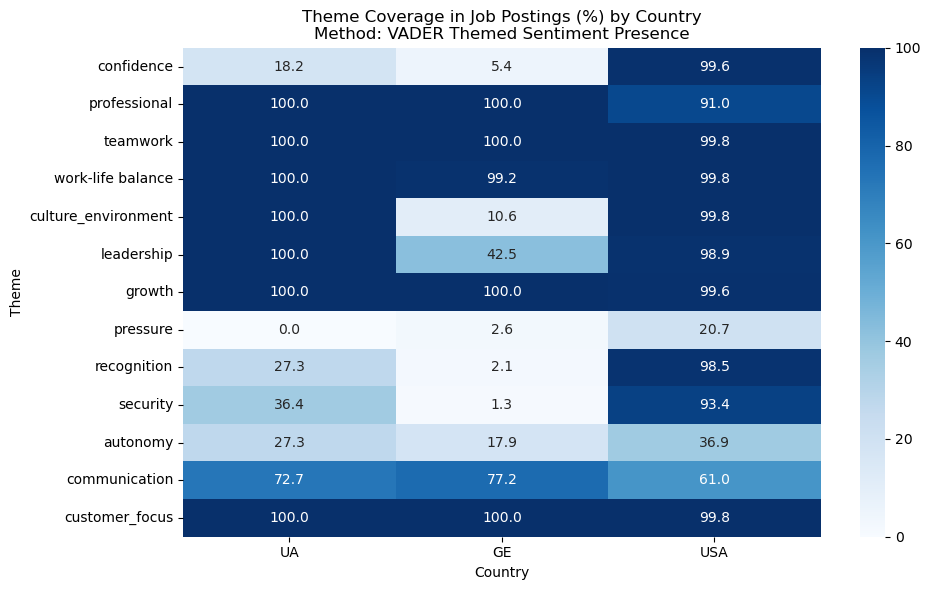

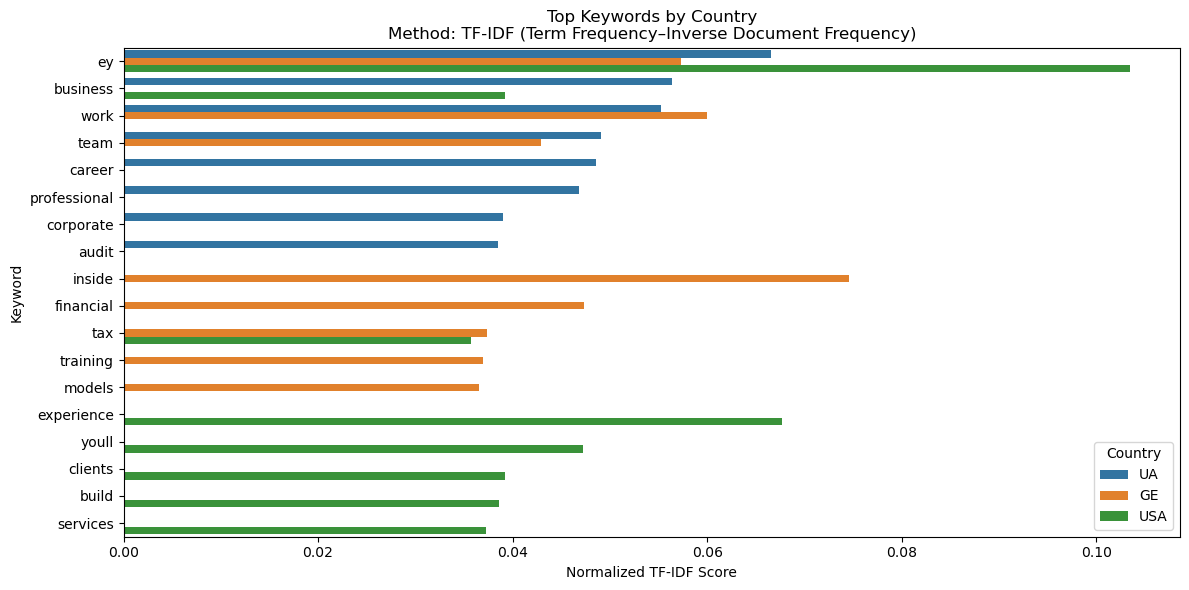

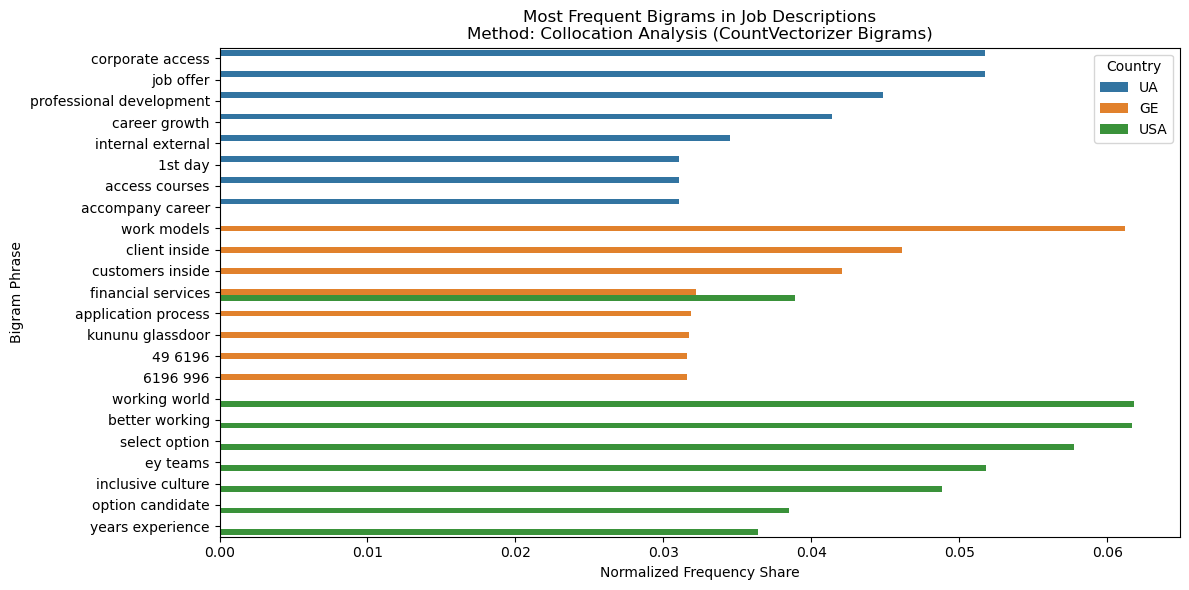

'\n# -------------------------------\n# STEP 4: LDA Topic Modeling — Regional Themes in Job Descriptions\n# -------------------------------\nimport pyLDAvis\nimport pyLDAvis.sklearn_model\n\nfrom sklearn.feature_extraction.text import TfidfVectorizer\nfrom sklearn.decomposition import LatentDirichletAllocation\n\ndef run_lda_on_job_ads(results_dict, num_topics=2, num_words=5):\n    topic_data = {}\n\n    for country in results_dict:\n        texts = results_dict[country]["Raw"]["Job Descriptions"]\n        if not texts:\n            continue\n\n        # Vectorize with TF-IDF (can also use CountVectorizer)\n        vectorizer = TfidfVectorizer(stop_words=\'english\', max_df=0.95, min_df=2)\n        X = vectorizer.fit_transform(texts)\n\n        lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)\n        lda.fit(X)\n\n        feature_names = vectorizer.get_feature_names_out()\n        topics = []\n        for idx, topic in enumerate(lda.components_):\n            

In [37]:
# %% ANALYTICAL FRAMEWORK. HYPOTHESIS 1 — Theme Differences Across Countries (Normalized, With Method Labels)

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

# -------------------------------
# Load processed NLP results
# -------------------------------
with open("text_analysis_results.pkl", "rb") as f:
    results_dict = pickle.load(f)

# -------------------------------
# STEP 1: Theme Coverage (VADER - Themed Sentiment Presence)
# -------------------------------
def plot_theme_coverage(results_dict):
    theme_coverage = {}
    for country, result in results_dict.items():
        theme_df = result["Sentiment"]["Themes"]
        theme_coverage[country] = theme_df.notnull().mean() * 100  # percent of postings that mention each theme

    df_theme_coverage = pd.DataFrame(theme_coverage).round(1)

    plt.figure(figsize=(10, 6))
    sns.heatmap(df_theme_coverage, annot=True, cmap="Blues", fmt=".1f")
    plt.title("Theme Coverage in Job Postings (%) by Country\nMethod: VADER Themed Sentiment Presence")
    plt.ylabel("Theme")
    plt.xlabel("Country")
    plt.tight_layout()
    plt.show()
    return df_theme_coverage

theme_table = plot_theme_coverage(results_dict)

# -------------------------------
# STEP 2: Top Keywords (TF-IDF - Normalized)
# -------------------------------
def plot_top_tfidf_terms_normalized(results_dict, top_n=10):
    all_data = []
    for country, result in results_dict.items():
        tfidf_dict = result["Keywords"]["TF-IDF"]
        total = sum(tfidf_dict.values()) or 1  # prevent division by zero
        top_terms = sorted(tfidf_dict.items(), key=lambda x: x[1], reverse=True)[:top_n]
        for term, score in top_terms:
            norm_score = score / total
            all_data.append({"Country": country, "Term": term, "Score (Normalized)": norm_score})
    df = pd.DataFrame(all_data)

    plt.figure(figsize=(12, 6))
    sns.barplot(data=df, x="Score (Normalized)", y="Term", hue="Country")
    plt.title("Top Keywords by Country\nMethod: TF-IDF (Term Frequency–Inverse Document Frequency)")
    plt.xlabel("Normalized TF-IDF Score")
    plt.ylabel("Keyword")
    plt.tight_layout()
    plt.show()
    return df

tfidf_table = plot_top_tfidf_terms_normalized(results_dict, top_n=8)

# -------------------------------
# STEP 3: Most Frequent Bigrams (Collocation Analysis - Normalized)
# -------------------------------
def plot_top_collocations_normalized(results_dict, top_n=10):
    all_data = []
    for country, result in results_dict.items():
        colloc_dict = result["Keywords"]["Collocations"]
        total = sum(colloc_dict.values()) or 1
        top_bigrams = sorted(colloc_dict.items(), key=lambda x: x[1], reverse=True)[:top_n]
        for bigram, count in top_bigrams:
            norm_score = count / total
            all_data.append({"Country": country, "Bigram": bigram, "Share (Normalized)": norm_score})
    df = pd.DataFrame(all_data)

    plt.figure(figsize=(12, 6))
    sns.barplot(data=df, x="Share (Normalized)", y="Bigram", hue="Country")
    plt.title("Most Frequent Bigrams in Job Descriptions\nMethod: Collocation Analysis (CountVectorizer Bigrams)")
    plt.xlabel("Normalized Frequency Share")
    plt.ylabel("Bigram Phrase")
    plt.tight_layout()
    plt.show()
    return df

colloc_table = plot_top_collocations_normalized(results_dict, top_n=8)

"""
# -------------------------------
# STEP 4: LDA Topic Modeling — Regional Themes in Job Descriptions
# -------------------------------
import pyLDAvis
import pyLDAvis.sklearn_model

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

def run_lda_on_job_ads(results_dict, num_topics=2, num_words=5):
    topic_data = {}

    for country in results_dict:
        texts = results_dict[country]["Raw"]["Job Descriptions"]
        if not texts:
            continue

        # Vectorize with TF-IDF (can also use CountVectorizer)
        vectorizer = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=2)
        X = vectorizer.fit_transform(texts)

        lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
        lda.fit(X)

        feature_names = vectorizer.get_feature_names_out()
        topics = []
        for idx, topic in enumerate(lda.components_):
            top_words = [feature_names[i] for i in topic.argsort()[-num_words:][::-1]]
            topics.append(f"Topic {idx+1}: " + ", ".join(top_words))
        
        topic_data[country] = topics

    return topic_data

lda_topics = run_lda_on_job_ads(results_dict)

# Display topics per country
for country, topics in lda_topics.items():
    print(f"\n🌍 LDA Topics for {country}:")
    for t in topics:
        print(f"  {t}")

"""

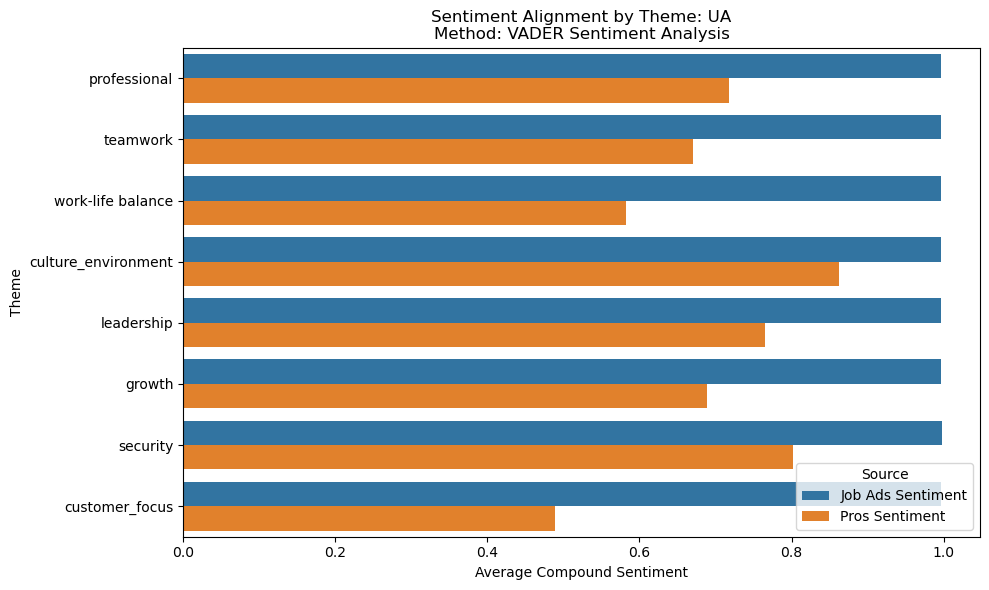

🔗 Pearson correlation for UA: 0.352


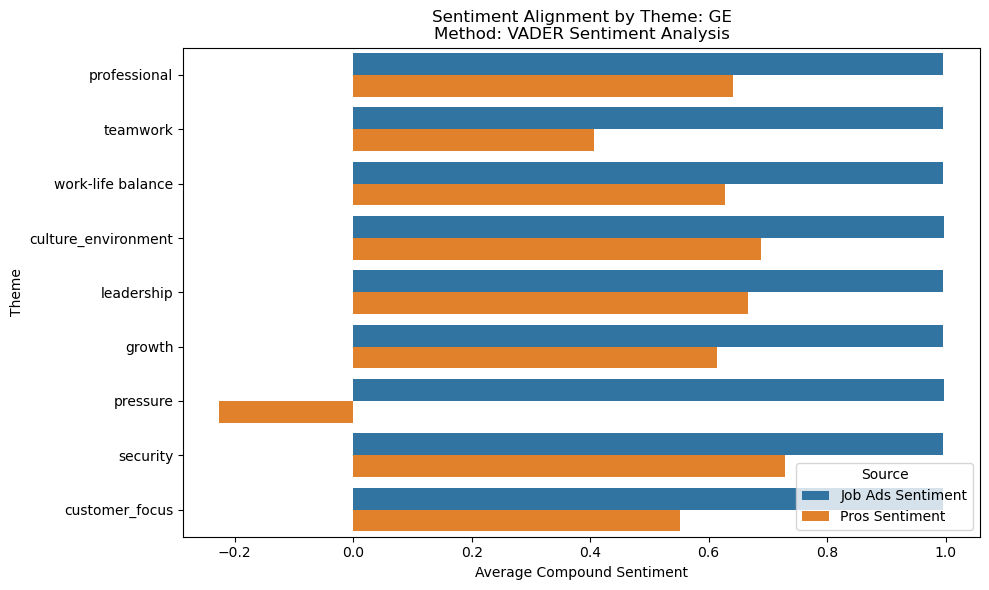

🔗 Pearson correlation for GE: -0.397


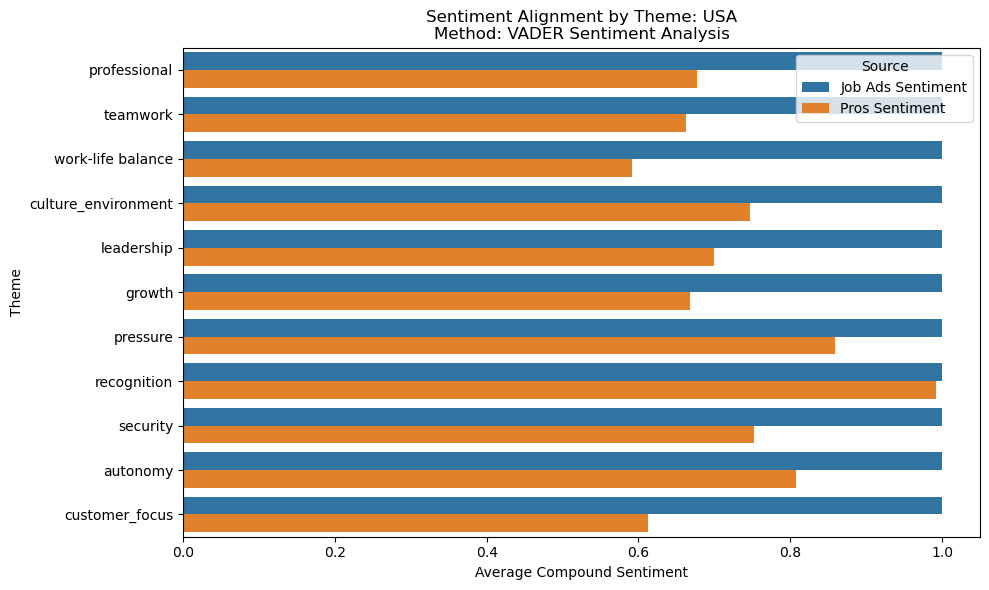

C:\Users\TE.5586\AppData\Local\Temp\ipykernel_18060\3265355978.py:94: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(df["Job Ads Sentiment"], df["Pros Sentiment"])


🔗 Pearson correlation for USA: nan


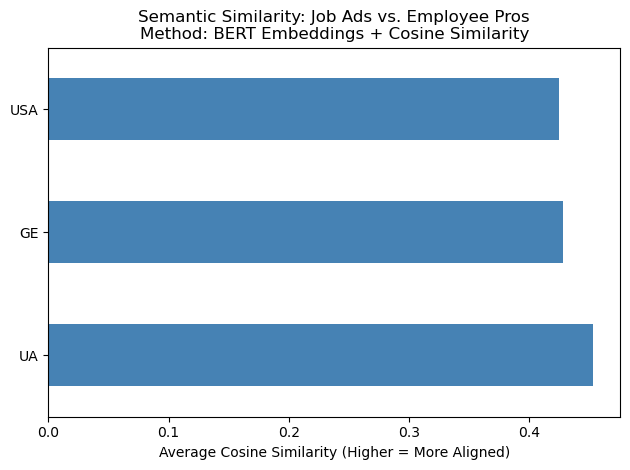

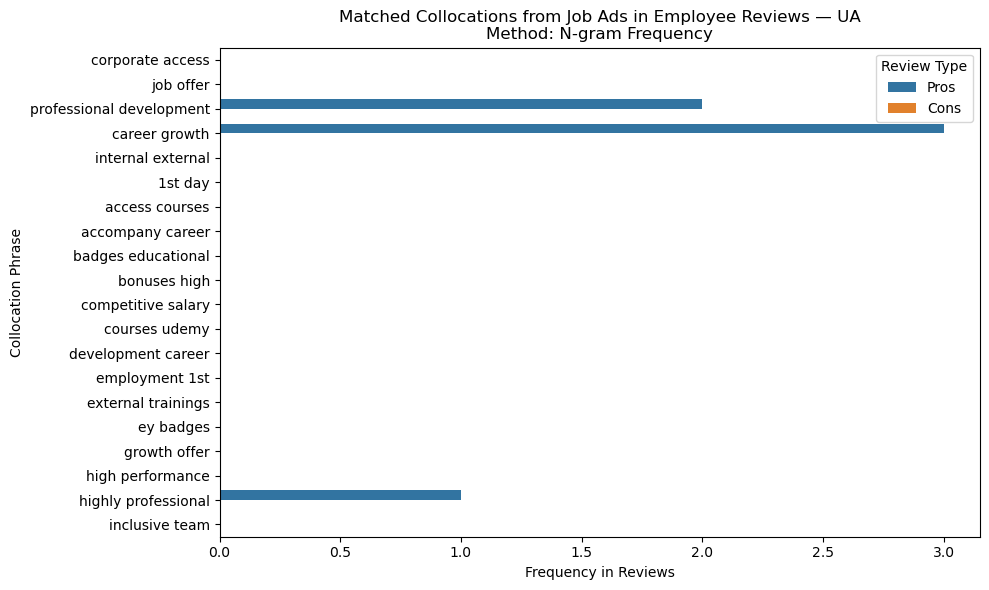

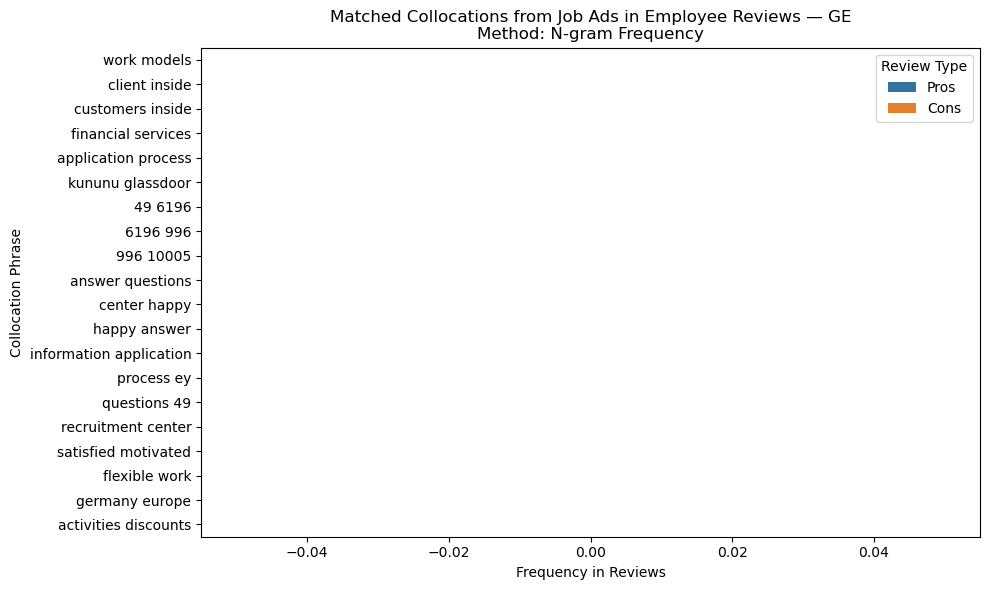

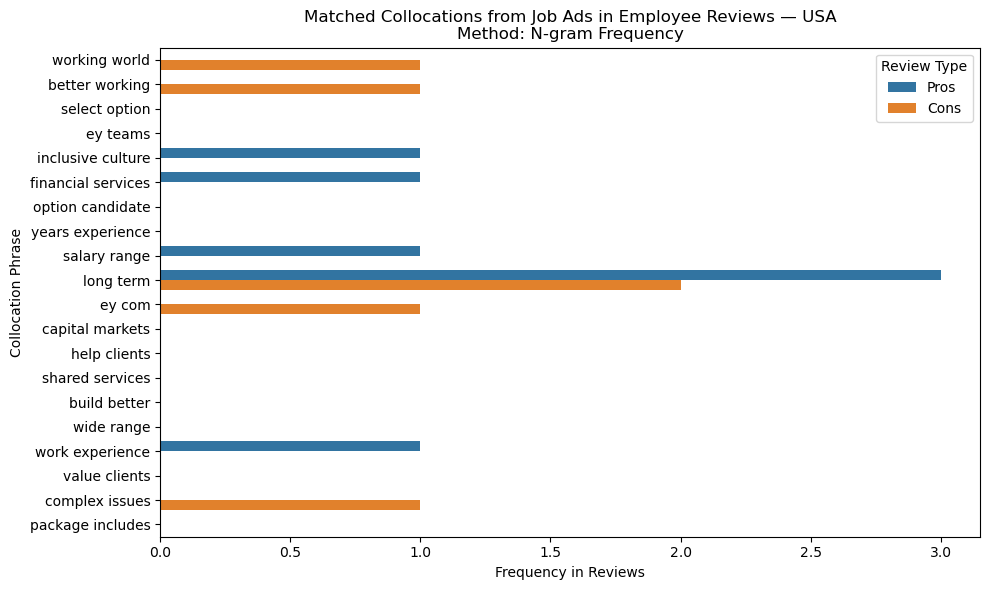

In [40]:
# %% ANALYTICAL FRAMEWORK. HYPOTHESIS 2 — Alignment Between Job Ads and Employee Reviews ("Pros")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk.sentiment import SentimentIntensityAnalyzer
from sentence_transformers import SentenceTransformer, util
from scipy.stats import pearsonr

# Initialize NLP tools
analyzer = SentimentIntensityAnalyzer()
model = SentenceTransformer('all-MiniLM-L6-v2')

themes = {
    'confidence': ['confidence', 'self-assured', 'self-confidence', 'assertive'],
    'professional': ['professional', 'professionalism', 'business-like', 'corporate'],
    'teamwork': ['teamwork', 'collaboration', 'team', 'cooperation', 'group work'],
    'work-life balance': ['worklife', 'work-life', 'remote', 'flexible', 'balance', 'well-being'],
    'culture_environment': ['supportive', 'toxic', 'inclusive', 'stressful', 'dynamic', 'collaborative'],
    'leadership': ['leadership', 'manager', 'mentor', 'guidance', 'supportive'],
    'growth': ['growth', 'development', 'training', 'career', 'promotion'],
    'pressure': ['fast-paced', 'deadline', 'pressure', 'intense', 'stressful'],
    'recognition': ['rewarded', 'recognized', 'valued', 'appreciated'],
    'security': ['job security', 'long-term', 'stable', 'turnover'],
    'autonomy': ['independent', 'autonomous', 'initiative', 'ownership'],
    'communication': ['communication', 'verbal', 'written', 'presentation'],
    'customer_focus': ['customer', 'client', 'user', 'support', 'service']
}

ad_sentiment = pd.DataFrame({
    country: results_dict[country]["Sentiment"]["Themes"].mean().round(3)
    for country in results_dict
})


# -------------------------------
# STEP 1: Extract Theme Sentiment from Employee "Pros"
# -------------------------------

def extract_pros_sentiment_only(review_dfs, themes):
    pros_theme_scores = {}

    for country, df in review_dfs.items():
        theme_scores = {theme: [] for theme in themes}
        pros_texts = df["Pros"].dropna().astype(str)

        for text in pros_texts:
            lowered_text = text.lower()
            for theme, keywords in themes.items():
                if any(k in lowered_text for k in keywords):
                    score = analyzer.polarity_scores(text)["compound"]
                    theme_scores[theme].append(score)

        avg_scores = {theme: np.mean(scores) if scores else None for theme, scores in theme_scores.items()}
        pros_theme_scores[country] = avg_scores

    return pd.DataFrame(pros_theme_scores).round(3)

pros_sentiment = extract_pros_sentiment_only(review_dfs, themes)

# -------------------------------
# STEP 2: Compare Theme Sentiment (Job Ads vs. Pros)
# -------------------------------

def identify_pros_alignment(ad_df, pros_df):
    tables = {}
    for country in ad_df.columns:
        job_sent = ad_df[country]
        pros_sent = pros_df[country]
        df = pd.DataFrame({
            "Theme": job_sent.index,
            "Job Ads Sentiment": job_sent.values,
            "Pros Sentiment": pros_sent.values
        }).dropna()

        df["Difference"] = df["Job Ads Sentiment"] - df["Pros Sentiment"]
        df["Aligned"] = (df["Job Ads Sentiment"].round(1) == df["Pros Sentiment"].round(1))
        tables[country] = df

    return tables

def plot_theme_alignment_barplots(alignment_tables):
    for country, df in alignment_tables.items():
        melted = df.melt(id_vars="Theme", value_vars=["Job Ads Sentiment", "Pros Sentiment"],
                         var_name="Source", value_name="Sentiment")
        plt.figure(figsize=(10, 6))
        sns.barplot(data=melted, x="Sentiment", y="Theme", hue="Source")
        plt.title(f"Sentiment Alignment by Theme: {country}\nMethod: VADER Sentiment Analysis")
        plt.xlabel("Average Compound Sentiment")
        plt.tight_layout()
        plt.show()

        corr, _ = pearsonr(df["Job Ads Sentiment"], df["Pros Sentiment"])
        print(f"🔗 Pearson correlation for {country}: {corr:.3f}")

# Run sentiment alignment
alignment_tables = identify_pros_alignment(ad_sentiment, pros_sentiment)
plot_theme_alignment_barplots(alignment_tables)

# -------------------------------
# STEP 3: Semantic Similarity – KeyBERT Phrases vs. Pros
# -------------------------------

def compute_semantic_similarity_keybert_to_pros(results_dict, review_dfs, model, top_n=50):
    similarity_scores = {}
    for country in results_dict:
        job_phrases = list(results_dict[country]["Keywords"]["KeyBERT"].keys())[:top_n]
        pros_texts = review_dfs[country]["Pros"].dropna().tolist()
        if not job_phrases or not pros_texts:
            similarity_scores[country] = None
            continue

        job_embeds = model.encode(job_phrases, convert_to_tensor=True)
        pros_embeds = model.encode(pros_texts, convert_to_tensor=True)
        cosine_sim = util.cos_sim(job_embeds, pros_embeds).cpu().numpy()
        avg_sim = np.mean(np.max(cosine_sim, axis=0))  # Most aligned phrase per review
        similarity_scores[country] = round(avg_sim, 3)

    return pd.Series(similarity_scores, name="Avg Semantic Similarity (Job Ads ↔ Pros)")

semantic_similarity_pros = compute_semantic_similarity_keybert_to_pros(results_dict, review_dfs, model)

# Plot semantic similarity
semantic_similarity_pros.plot(kind='barh',
    title="Semantic Similarity: Job Ads vs. Employee Pros\nMethod: BERT Embeddings + Cosine Similarity",
    color='steelblue')
plt.xlabel("Average Cosine Similarity (Higher = More Aligned)")
plt.tight_layout()
plt.show()

# -------------------------------
# STEP 4: Phrase Frequency – Collocations in Pros/Cons
# -------------------------------

def collocation_frequencies_in_reviews(results_dict, review_dfs, top_n=20):
    freq_data = {}

    for country in results_dict:
        colloc_items = list(results_dict[country]["Keywords"]["Collocations"].items())[:top_n]
        colloc_phrases = [phrase.lower() for phrase, _ in colloc_items]

        pros_text = " ".join(review_dfs[country]["Pros"].dropna().astype(str)).lower()
        cons_text = " ".join(review_dfs[country]["Cons"].dropna().astype(str)).lower()

        data = []
        for phrase in colloc_phrases:
            pros_count = pros_text.count(phrase)
            cons_count = cons_text.count(phrase)
            data.append({
                "Phrase": phrase,
                "Pros": pros_count,
                "Cons": cons_count
            })

        df = pd.DataFrame(data)
        freq_data[country] = df

    return freq_data

def plot_collocation_review_comparison(freq_data):
    for country, df in freq_data.items():
        df_melted = df.melt(id_vars="Phrase", var_name="Review Type", value_name="Frequency")
        plt.figure(figsize=(10, 6))
        sns.barplot(data=df_melted, x="Frequency", y="Phrase", hue="Review Type")
        plt.title(f"Matched Collocations from Job Ads in Employee Reviews — {country}\nMethod: N-gram Frequency")
        plt.xlabel("Frequency in Reviews")
        plt.ylabel("Collocation Phrase")
        plt.tight_layout()
        plt.show()

# Run and visualize
colloc_review_freqs = collocation_frequencies_in_reviews(results_dict, review_dfs, top_n=20)
plot_collocation_review_comparison(colloc_review_freqs)



📍 Theme Sentiment Comparison (Job Ads vs. Cons) – UA


,Theme,Job Ads Sentiment,Cons Sentiment,Mentions,Difference,Note
3,work-life balance,0.9968,-0.211,28,1.2078,❗ Potential mismatch
4,culture_environment,0.9968,-0.560,6,1.5568,❗ Potential mismatch
5,leadership,0.9968,-0.070,5,1.0668,❗ Potential mismatch
11,communication,0.997725,-0.791,1,1.788725,❗ Potential mismatch
12,customer_focus,0.9968,-0.157,3,1.1538,❗ Potential mismatch
6,growth,0.9968,0.061,6,0.9358,
9,security,0.99795,0.000,1,0.99795,



📍 Theme Sentiment Comparison (Job Ads vs. Cons) – GE


,Theme,Job Ads Sentiment,Cons Sentiment,Mentions,Difference,Note
3,work-life balance,0.995,-0.157,17,1.152,❗ Potential mismatch
4,culture_environment,0.997,-0.644,2,1.641,❗ Potential mismatch
7,pressure,0.997,-0.363,6,1.360,❗ Potential mismatch
11,communication,0.995,-0.201,2,1.196,❗ Potential mismatch
1,professional,0.995,0.664,2,0.331,
2,teamwork,0.995,0.036,7,0.959,
5,leadership,0.996,0.474,2,0.522,
6,growth,0.995,0.205,5,0.790,
8,recognition,0.999,0.527,1,0.472,
12,customer_focus,0.995,0.077,4,0.918,



📍 Theme Sentiment Comparison (Job Ads vs. Cons) – USA


,Theme,Job Ads Sentiment,Cons Sentiment,Mentions,Difference,Note
2,teamwork,1.0,-0.019,39,1.019,❗ Potential mismatch
3,work-life balance,1.0,-0.144,50,1.144,❗ Potential mismatch
4,culture_environment,1.0,-0.236,22,1.236,❗ Potential mismatch
5,leadership,1.0,-0.148,45,1.148,❗ Potential mismatch
7,pressure,1.0,-0.287,29,1.287,❗ Potential mismatch
8,recognition,1.0,-0.472,2,1.472,❗ Potential mismatch
10,autonomy,1.0,-0.599,1,1.599,❗ Potential mismatch
12,customer_focus,1.0,-0.028,45,1.028,❗ Potential mismatch
1,professional,1.0,0.061,8,0.939,
6,growth,1.0,0.043,35,0.957,


C:\Users\TE.5586\AppData\Local\Temp\ipykernel_18060\3560994476.py:92: UserWarning: Glyph 10071 (\N{HEAVY EXCLAMATION MARK SYMBOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\TE.5586\AppData\Local\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10071 (\N{HEAVY EXCLAMATION MARK SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


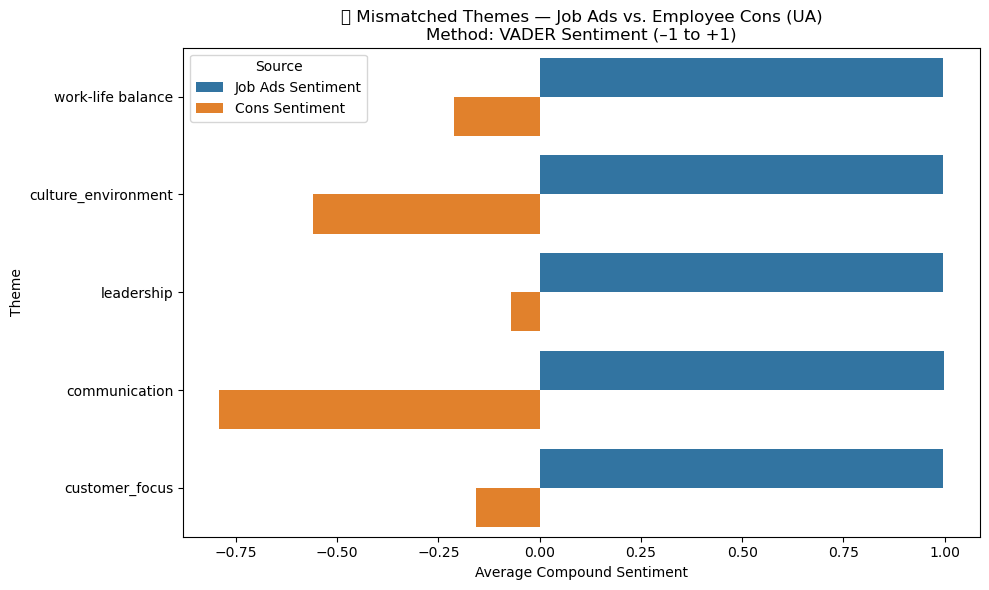

C:\Users\TE.5586\AppData\Local\Temp\ipykernel_18060\3560994476.py:92: UserWarning: Glyph 10071 (\N{HEAVY EXCLAMATION MARK SYMBOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\TE.5586\AppData\Local\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10071 (\N{HEAVY EXCLAMATION MARK SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


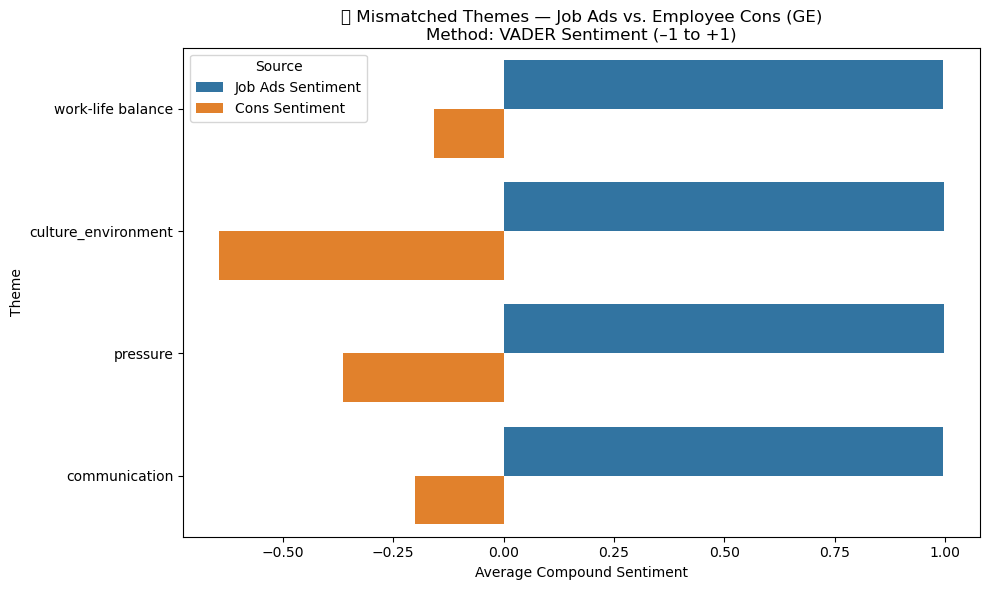

C:\Users\TE.5586\AppData\Local\Temp\ipykernel_18060\3560994476.py:92: UserWarning: Glyph 10071 (\N{HEAVY EXCLAMATION MARK SYMBOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\TE.5586\AppData\Local\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10071 (\N{HEAVY EXCLAMATION MARK SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


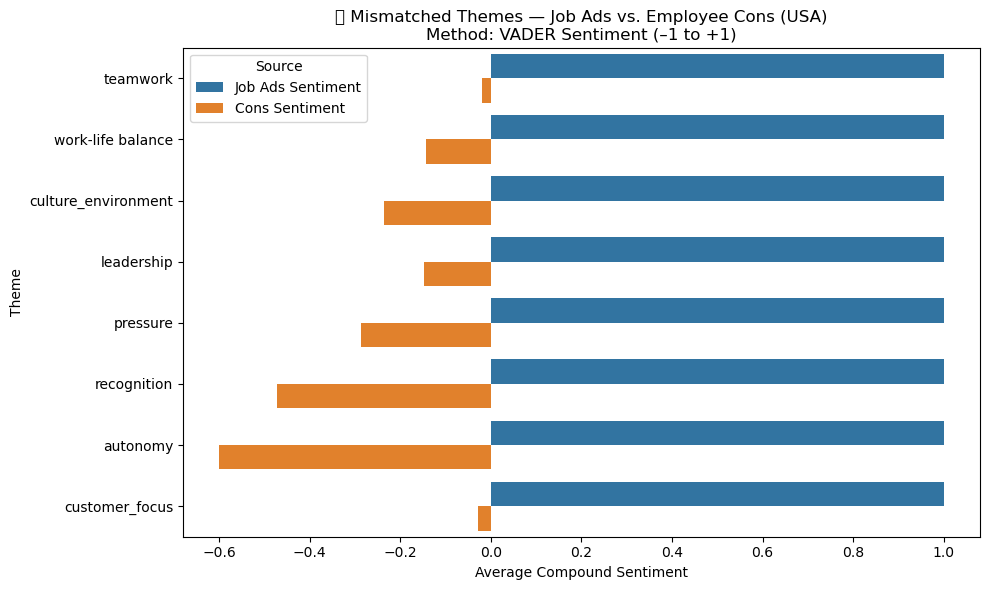

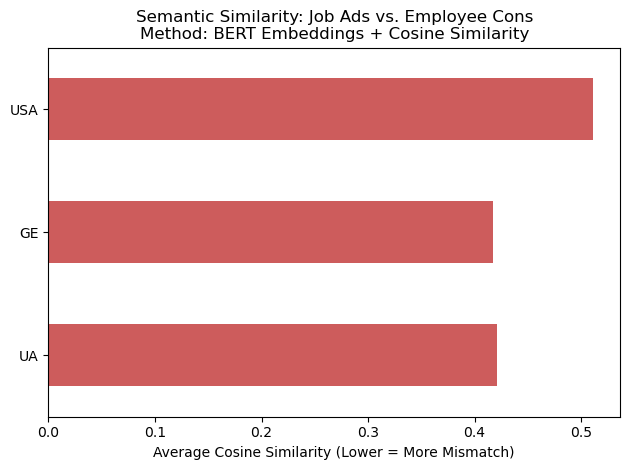

In [39]:
# %% ANALYTICAL FRAMEWORK. HYPOTHESIS 3 — Misalignment Between Employer Branding and Employee Feedback ("Cons")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk.sentiment import SentimentIntensityAnalyzer
from sentence_transformers import SentenceTransformer, util

# Initialize tools
analyzer = SentimentIntensityAnalyzer()
model = SentenceTransformer('all-MiniLM-L6-v2')

# ---------------------------------
# STEP 1: Extract Theme Sentiment + Mentions from "Cons"
# ---------------------------------
def extract_cons_sentiment_and_mentions(review_dfs, themes):
    cons_theme_sentiments = {}
    cons_theme_mentions = {}

    for country, df in review_dfs.items():
        theme_scores = {theme: [] for theme in themes}
        theme_mentions = {theme: 0 for theme in themes}
        cons_texts = df["Cons"].dropna().astype(str)

        for text in cons_texts:
            lowered_text = text.lower()
            for theme, keywords in themes.items():
                if any(k in lowered_text for k in keywords):
                    theme_mentions[theme] += 1
                    score = analyzer.polarity_scores(text)["compound"]
                    theme_scores[theme].append(score)

        avg_scores = {theme: np.mean(scores) if scores else None for theme, scores in theme_scores.items()}
        cons_theme_sentiments[country] = avg_scores
        cons_theme_mentions[country] = theme_mentions

    return pd.DataFrame(cons_theme_sentiments).round(3), pd.DataFrame(cons_theme_mentions)

# Extract
cons_sentiment, cons_mentions = extract_cons_sentiment_and_mentions(review_dfs, themes)

# ---------------------------------
# STEP 2: Identify Sentiment Mismatches
# ---------------------------------
def identify_cons_mismatches(ad_df, cons_df, mention_df, threshold_ad=0.2, threshold_cons=0.0):
    mismatch_tables = {}

    for country in ad_df.columns:
        job_sent = ad_df[country]
        cons_sent = cons_df[country]
        mentions = mention_df[country]
        df = pd.DataFrame({
            "Theme": job_sent.index,
            "Job Ads Sentiment": job_sent.values,
            "Cons Sentiment": cons_sent.values,
            "Mentions": mentions.values
        }).dropna()

        df["Difference"] = df["Job Ads Sentiment"] - df["Cons Sentiment"]
        df["Mismatch"] = (df["Job Ads Sentiment"] > threshold_ad) & (df["Cons Sentiment"] < threshold_cons)
        df["Note"] = df["Mismatch"].apply(lambda x: "❗ Potential mismatch" if x else "")

        mismatch_tables[country] = df.sort_values(by="Mismatch", ascending=False)

    return mismatch_tables

def display_cons_mismatch_tables(mismatch_tables):
    for country, df in mismatch_tables.items():
        print(f"\n📍 Theme Sentiment Comparison (Job Ads vs. Cons) – {country}")
        display(df[["Theme", "Job Ads Sentiment", "Cons Sentiment", "Mentions", "Difference", "Note"]])

def plot_cons_mismatch_bars(mismatch_tables):
    for country, df in mismatch_tables.items():
        mismatches = df[df["Mismatch"]]
        if mismatches.empty:
            print(f"No significant mismatches found for {country}.")
            continue

        melted = mismatches.melt(
            id_vars="Theme",
            value_vars=["Job Ads Sentiment", "Cons Sentiment"],
            var_name="Source",
            value_name="Sentiment"
        )

        plt.figure(figsize=(10, 6))
        sns.barplot(data=melted, x="Sentiment", y="Theme", hue="Source")
        plt.title(f"❗ Mismatched Themes — Job Ads vs. Employee Cons ({country})\nMethod: VADER Sentiment (–1 to +1)")
        plt.xlabel("Average Compound Sentiment")
        plt.ylabel("Theme")
        plt.tight_layout()
        plt.show()

# Run sentiment mismatch analysis
cons_mismatch_results = identify_cons_mismatches(ad_sentiment, cons_sentiment, cons_mentions)
display_cons_mismatch_tables(cons_mismatch_results)
plot_cons_mismatch_bars(cons_mismatch_results)

# ---------------------------------
# STEP 3: Embedding-Based Semantic Similarity (Job Ads vs. Cons)
# ---------------------------------
def compute_embedding_mismatch(results_dict, review_dfs, top_n_phrases=30):
    mismatch_scores = {}

    for country in results_dict:
        job_phrases = list(results_dict[country]["Keywords"]["KeyBERT"].keys())[:top_n_phrases]
        if not job_phrases:
            mismatch_scores[country] = None
            continue

        cons_texts = review_dfs[country]["Cons"].dropna().tolist()
        if not cons_texts:
            mismatch_scores[country] = None
            continue

        job_embeds = model.encode(job_phrases, convert_to_tensor=True)
        cons_embeds = model.encode(cons_texts, convert_to_tensor=True)

        cosine_sim = util.cos_sim(job_embeds, cons_embeds).cpu().numpy()
        avg_sim = np.mean(np.max(cosine_sim, axis=1))
        mismatch_scores[country] = round(avg_sim, 3)

    return pd.Series(mismatch_scores, name="Avg Semantic Similarity (Ads vs. Cons)")

# Run and visualize
embedding_mismatch = compute_embedding_mismatch(results_dict, review_dfs)
embedding_mismatch.plot(
    kind='barh',
    title="Semantic Similarity: Job Ads vs. Employee Cons\nMethod: BERT Embeddings + Cosine Similarity",
    color='indianred'
)
plt.xlabel("Average Cosine Similarity (Lower = More Mismatch)")
plt.tight_layout()
plt.show()
